## Загрузка данных

In [2]:
import os
import hashlib
import re
from pysistant import helpers
import librosa


In [3]:
source_dir = './speech_commands_v0.01'
source_files = [item for item in helpers.find_files(source_dir, '.wav')]


In [4]:
len(source_files)


64727

In [5]:
MAX_NUM_WAVS_PER_CLASS = 2 ** 27 - 1  # ~134M

                                                                  
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
      filename: File path of the data sample.
      validation_percentage: How much of the data set to use for validation.
      testing_percentage: How much of the data set to use for testing.

    Returns:
      String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.

    hash_name_hashed = hashlib.sha1(str(hash_name).encode('utf-8')).hexdigest()

    percentage_hash = ((int(hash_name_hashed, 16) %
                        (MAX_NUM_WAVS_PER_CLASS + 1)) *
                       (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'

    return result

In [6]:
def get_class_name(file_path):
    return file_path.split('\\')[-2]


In [7]:
train_files = []
val_files = []
test_files = []
class_to_id = {}
dict_duration = {}
set_sr = set() 
max_shape = 0
id = 0
for file_path in source_files:
    class_name = get_class_name(file_path)

    if class_name not in class_to_id.keys():
        class_to_id[class_name] = id
        id += 1

    samples, sample_rate = librosa.load(file_path, sr=None)
    if len(samples.shape) > 1:
        max_shape = samples.shape

    duration = str(len(samples) / sample_rate)
    if duration in dict_duration.keys():
        dict_duration[duration] += 1
    else:
        dict_duration[duration] = 1

    set_sr.add(sample_rate)

    part_type = which_set(file_path, 10, 10)
    if part_type == 'training':
        train_files.append(file_path)
    elif part_type == 'validation':
        val_files.append(file_path)
    elif part_type == 'testing':
        test_files.append(file_path)


In [8]:
len(train_files)

51094

In [9]:
samples, sample_rate = librosa.load(source_files[3], sr=None)
print(samples)
print(sample_rate)

[-0.00024414 -0.00033569 -0.00033569 ...  0.00039673  0.00030518
  0.00048828]
16000


In [10]:
print(dict_duration)
print(class_to_id)

{'1.0': 58252, '0.9288125': 478, '0.853375': 451, '0.981375': 715, '0.97525': 494, '0.8106875': 406, '0.9386875': 632, '0.882375': 402, '0.7895': 265, '0.8359375': 331, '0.896': 503, '0.7430625': 215, '0.696625': 157, '0.96': 21, '0.7466875': 6, '0.821375': 6, '0.6826875': 176, '0.704': 4, '0.5546875': 70, '0.469375': 6, '0.789375': 10, '0.6501875': 83, '0.8746875': 11, '0.768': 269, '0.725375': 259, '0.905625': 3, '0.512': 53, '0.9066875': 4, '0.992': 5, '0.60375': 59, '0.5573125': 35, '0.9706875': 7, '0.597375': 88, '0.64': 111, '0.4906875': 1, '0.736': 4, '0.885375': 3, '0.510875': 17, '0.8426875': 2, '0.7663125': 3, '0.9520625': 3, '0.6186875': 3, '0.4644375': 11, '0.7786875': 2, '0.757375': 5, '0.832': 8, '0.418': 4, '0.384': 1, '0.9670625': 1, '0.917375': 12, '0.8': 5, '0.565375': 4, '0.629375': 1, '0.693375': 1, '0.4586875': 2, '0.627': 1, '0.9470625': 3, '0.5866875': 4, '0.533375': 1, '0.501375': 3, '0.949375': 4, '0.672': 2, '0.9985': 2, '0.928': 3, '0.6506875': 1, '0.4266875'

In [11]:
# использование функции из класса SoundDS для построения аугментации
def pad_trunc(samples, sr):
        num_rows, signal_len = samples.shape
        max_len = sr // 1000 * 1000

        if (signal_len > max_len):
            # Truncate the signal to the given length
            samples = samples[:, :max_len]

        elif (signal_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((1, pad_begin_len))
            pad_end = torch.zeros((1, pad_end_len))

            samples = torch.cat((pad_begin, samples, pad_end), 1)

        return samples


## Построение аугментаций на исходном сигнале с помощью библиотеки audiomentations

In [12]:
from audiomentations import Compose, PitchShift, AddGaussianNoise, TimeStretch, Shift()

In [160]:
## в метод Compose() подставлялись: 

PitchShift()
AddGaussianNoise()

TimeStretch()

Shift()

In [ ]:
## Пример функции с использованием Shift()

In [140]:
def augmented_dataset(dataset):
    augmented_dataset = []
    augment = Compose([
        Shift()
    ])
    count = 0
    for file_path in dataset:
        count += 1
        if count % 100 == 0:
            print(count)
        samples, sr = torchaudio.load(file_path)
        #выравниваем по длине звук (убираем, добавляем сэмплы)
        samples = pad_trunc(samples, sr)
        transform_audio = augment(samples.numpy(), sr)
        augmented_dataset.append((transform_audio, sr))
    return augmented_dataset
        

In [141]:
augmented_data = augmented_dataset(train_files)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

## Сохранение данных для перезапуска ноутбука без повторной аугментации

In [143]:
import soundfile as sf
for i in range(len(augmented_data)):
    name = "augment_time_shift/time_shift_" + str(i) +".wav"
    if torch.is_tensor(augmented_data[i][0]): 
        torchaudio.save(name, augmented_data[i][0], augmented_data[i][1])
    else:
        torchaudio.save(name, torch.from_numpy(augmented_data[i][0]), augmented_data[i][1])
        
    

## Функции отображения и воспроизведения функций

In [27]:
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [145]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

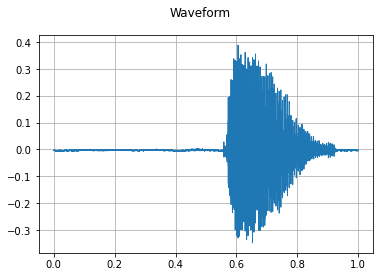

In [146]:
plot_waveform(samples, sr)

In [147]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        return Audio(waveform[0], rate=sample_rate)
    elif num_channels == 2:
        return Audio((waveform[0], waveform[1]), rate=sample_rate)
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [126]:
play_audio(transform_audio, sr)

In [302]:
play_audio(torch.from_numpy(transform_audio), sr)

## Создание датасета
Функция видоизменялась для использования методов к исходному аудиосигналу и для применения аугментаций к спектрограммам. 

In [15]:
import random
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split


class SoundDS(Dataset):
    
    def __init__(self, source_files=[], augmentated_data=[], class_to_id={}):
        self.source_files = source_files
        self.duration = 1000 #длительность
        self.sr = 16000 #частота дисркетизации
        self.class_to_id = class_to_id
        self.n_fft = 1024 #количетсво отсчетов на кадр
        self.hop_length = None #масштаб времени по оси
        self.n_mels = 64 #duration/window_of_fft
        self.top_db = 80 #пороговое значение, дальше - тишина
        self.augmentated_data = augmentated_data

    def __len__(self):
        return len(self.source_files) + len(self.augmentated_data)
    
    def get_elem(self, idx):
        return self.source_files[idx]
    
    def __getitem__(self, idx):
        if idx < len(self.source_files):
            #return self.augmentated_data[idx-len(self.source_files)][0], self.augmentated_data[idx-len(self.source_files)][1]
            file_path = self.source_files[idx]
            class_id = self.class_to_id[get_class_name(file_path)]

            samples, sr = torchaudio.load(file_path)
            #выравниваем по длине звук (убираем, добавляем сэмплы)
            samples = self._pad_trunc(samples, self.sr)
        else:
            if torch.is_tensor(self.augmentated_data[idx-len(self.source_files)][0]):
                samples, sr = self.augmentated_data[idx-len(self.source_files)]
            else:
                samples = torch.from_numpy(self.augmentated_data[idx-len(self.source_files)][0])
                sr = self.augmentated_data[idx-len(self.source_files)][1]
                
        # spect has shape [channel, n_mels, time], where channel is mono, stereo etc
        spect = torchaudio.transforms.MelSpectrogram(
            self.sr,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )(samples)
        
        spect = torchaudio.transforms.AmplitudeToDB(top_db=self.top_db)(spect)
     
        
        spect = self.rechannel(spect, self.sr, 3)
        if idx >= len(self.source_files):
            file_path = self.source_files[idx-len(self.augmentated_data)]
            class_id = self.class_to_id[get_class_name(file_path)]
            return spect, class_id
        return spect, class_id
    def append_file(self, spectrogram):
        self.augmentated_data.append(spectrogram)

    def _pad_trunc(self, samples, sr):
        num_rows, signal_len = samples.shape
        max_len = sr // 1000 * self.duration

        if (signal_len > max_len):
            # Truncate the signal to the given length
            samples = samples[:, :max_len]

        elif (signal_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((1, pad_begin_len))
            pad_end = torch.zeros((1, pad_end_len))

            samples = torch.cat((pad_begin, samples, pad_end), 1)

        return samples

    def rechannel(self, spect, sr, num_channel):
        if (spect.shape[0] == num_channel):
            # Nothing to do
            return spect

        if (num_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            spect = spect[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            spect = torch.cat([spect, spect, spect])

        return spect
    # [+- 0.005 c +- 0.2]
    def _time_shift(self, samples, sr, shift_limit):
        _, sig_len = samples.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return samples.roll(shift_amt)
    



## Применение SpecAugment к спектрограммам, получение допольнительного набора данных

In [220]:
def get_dataset_augmentation():
    exceptions = list()
    try:
        augmentated = list()
        for i in range(len(train_files)):  
            data = train_dataset.__getitem__(i)
            spectro = data[0]
            class_name = data[1]
            combined = time_mask(freq_mask(spectro, num_masks=2), num_masks=2)
            augmentated.append((combined, class_name))
    except Exception as e:
        exceptions.append(i)
    return augmentated

In [279]:
spec_augment_data = get_dataset_augmentation()
print(len(spec_augment_data))

51094


## Формирование датасетов для SpecAugment

In [280]:
train_dataset = SoundDS(source_files=train_files, augmentated_data=spec_augment_data, class_to_id=class_to_id)
valid_dataset = SoundDS(source_files=val_files, augmentated_data=[], class_to_id=class_to_id)
test_dataset = SoundDS(source_files=test_files, augmentated_data=[], class_to_id=class_to_id)


## Формирование датасетов для аугментаций к исходному сигналу

In [148]:
train_dataset = SoundDS(source_files=train_files, augmentated_data=augmented_data, class_to_id=class_to_id)
valid_dataset = SoundDS(source_files=val_files, augmentated_data=[], class_to_id=class_to_id)
test_dataset = SoundDS(source_files=test_files, augmentated_data=[], class_to_id=class_to_id)

In [149]:
print(train_dataset.__getitem__(56000))

(tensor([[[-23.5580, -39.3586, -34.0950,  ..., -35.1478, -35.0645, -10.9306],
         [-21.4407, -26.0326, -27.2101,  ..., -26.2061, -36.1472, -12.1085],
         [-13.8759, -15.4908, -17.0735,  ..., -16.5422, -19.0861, -10.2180],
         ...,
         [-27.0626, -44.2584, -44.2584,  ..., -25.5987, -27.1748, -29.4739],
         [-26.7536, -44.2584, -44.2584,  ..., -19.7891, -19.4646, -27.5089],
         [-26.4728, -44.2584, -44.2584,  ..., -31.5461, -28.3493, -29.4561]],

        [[-23.5580, -39.3586, -34.0950,  ..., -35.1478, -35.0645, -10.9306],
         [-21.4407, -26.0326, -27.2101,  ..., -26.2061, -36.1472, -12.1085],
         [-13.8759, -15.4908, -17.0735,  ..., -16.5422, -19.0861, -10.2180],
         ...,
         [-27.0626, -44.2584, -44.2584,  ..., -25.5987, -27.1748, -29.4739],
         [-26.7536, -44.2584, -44.2584,  ..., -19.7891, -19.4646, -27.5089],
         [-26.4728, -44.2584, -44.2584,  ..., -31.5461, -28.3493, -29.4561]],

        [[-23.5580, -39.3586, -34.0950,  ..

## Блок нагладяного отображения спектрограмм с применением аугментаций к исходному сигналу и SpeccAugment к самой спектрограмме

In [151]:
#метод рисования спектрограммы
def tensor_to_img(spectrogram):
    plt.figure(figsize=(9,4)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

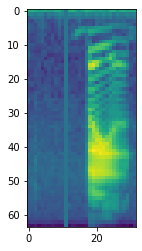

torch.Size([3, 64, 32])

In [282]:
# спектрограмма после наложения частотной маски
tensor_to_img(spec_augment_data[1][0])

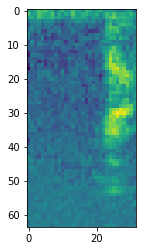

torch.Size([3, 64, 32])

In [223]:
# спектрограмма после применения добавления гауссовского шума и изменения высота тона
spectro = train_dataset.__getitem__(55000)[0]
tensor_to_img(spectro)


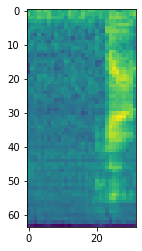

torch.Size([3, 64, 32])

In [152]:
# спектрограмма после растягивание времени
spectro = train_dataset.__getitem__(55000)[0]
tensor_to_img(spectro)

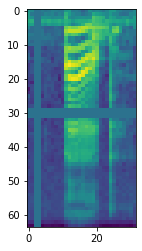

torch.Size([3, 64, 32])

In [183]:
# спектрограмма после применения частотной и временной маски
combined = time_mask(freq_mask(spectro, num_masks=2), num_masks=2)
tensor_to_img(combined)

## Блок использования и тестирования временных и частотных масок

In [ ]:
def test_time_warp():
    torch.device('cpu')
    print(type(spectro))
    print(spectro)
    tensor_to_img(time_warp(spectro))
    
tensor_to_img(spectro)    
test_time_warp()

In [182]:
# функция частотного маскирования SpecAugment
def freq_mask(spec, F=5, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        if f >= num_mel_channels:
            return cloned
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

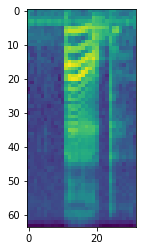

torch.Size([3, 64, 32])

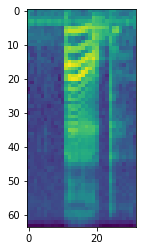

torch.Size([3, 64, 32])

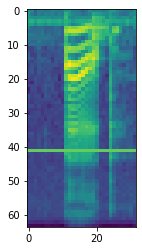

torch.Size([3, 64, 32])

In [181]:
def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
test_freq_mask()

In [162]:
# функция временного маскирования SpecAugment
def time_mask(spec, T=5, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        if t >= len_spectro:
            return cloned
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

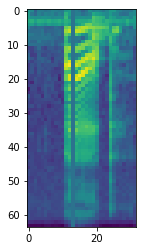

torch.Size([3, 64, 32])

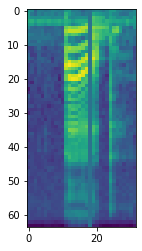

torch.Size([3, 64, 32])

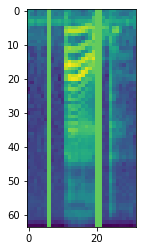

torch.Size([3, 64, 32])

In [159]:
def test_time_mask():
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask()

## Деление на батчи

In [153]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Загрузка модели, loss-функции и оптимизатора

In [154]:
import torchvision.models as models

device = 'cpu'
model = models.resnet18().to(device)


In [155]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


## Функции обучения, валидационной проверки и тестовой

In [156]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    exceptions = list()
    batch = -1
    try:
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    except Exception as e:
        exceptions.append(batch)
    print(exceptions)


In [157]:
def validation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [158]:
from sklearn.metrics import classification_report
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    y_true = list()
    y_pred = list()
    with torch.no_grad():
        for X, y in dataloader:
            y_true.append(y)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred.append(pred)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    correct /= size
    
    #print(classification_report(torch.cat(y_true), torch.cat(y_pred)))
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}\n")
    return (y_true, y_pred)
    

## Результаты AddGaussianNoise() на тестовой выборке

In [264]:
# model.eval()
y_true, y_pred = test(test_dataloader, model)

Test Error: 
 Accuracy: 90.8



In [277]:
y_true_tensor = torch.cat((torch.cat(y_true[:1+1]),torch.cat(y_true[1+1:])))
y_pred_tensor = torch.cat((torch.cat(y_pred[:1+1]),torch.cat(y_pred[1+1:])))
print(classification_report(y_true_tensor.tolist(), y_pred_tensor.argmax(1).tolist()))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       176
           1       0.97      0.87      0.92       158
           2       0.92      0.95      0.94       166
           3       0.95      0.87      0.91       180
           4       0.91      0.89      0.90       253
           5       0.93      0.95      0.94       257
           6       0.90      0.91      0.91       271
           7       0.92      0.94      0.93       253
           8       0.77      0.87      0.82       251
           9       0.92      0.98      0.95       180
          10       0.94      0.97      0.95       150
          11       0.92      0.88      0.90       267
          12       0.94      0.95      0.95       162
          13       0.91      0.94      0.92       259
          14       0.85      0.85      0.85       252
          15       0.95      0.90      0.92       262
          16       0.93      0.90      0.91       246
          17       0.94    

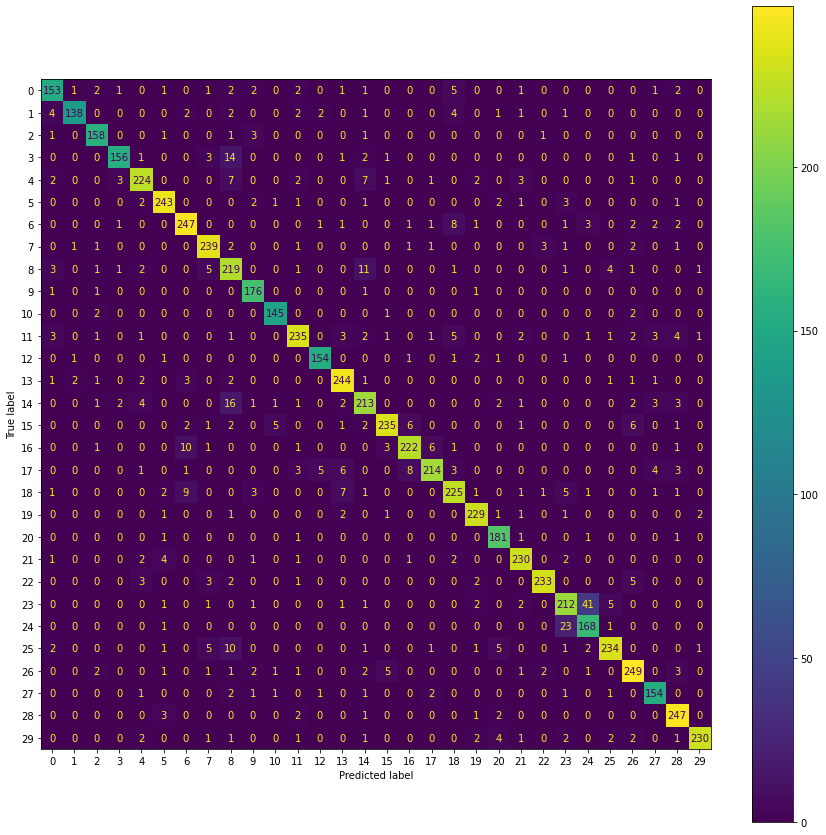

In [314]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_tensor.tolist(), y_pred_tensor.argmax(1).tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(30))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)

## Фрагмент обучения данных Time Stretch

In [135]:
# с 1 по 3 эпохи
epochs = 3
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(val_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 7.206888  [    0/102188]
loss: 2.804645  [ 6400/102188]
loss: 1.581532  [12800/102188]
loss: 1.106920  [19200/102188]
loss: 0.654116  [25600/102188]
loss: 0.694478  [32000/102188]
loss: 0.530367  [38400/102188]
loss: 0.733920  [44800/102188]
loss: 0.394398  [51200/102188]
loss: 0.426339  [57600/102188]
loss: 0.558372  [64000/102188]
loss: 0.621524  [70400/102188]
loss: 0.482066  [76800/102188]
loss: 0.643620  [83200/102188]
loss: 0.448813  [89600/102188]
loss: 0.212729  [96000/102188]
[]
Val Error: 
 Accuracy: 87.1%, Avg loss: 0.429177 

Epoch 2
-------------------------------
loss: 0.265502  [    0/102188]
loss: 0.383048  [ 6400/102188]
loss: 0.284501  [12800/102188]
loss: 0.410498  [19200/102188]
loss: 0.251789  [25600/102188]
loss: 0.225532  [32000/102188]
loss: 0.240516  [38400/102188]
loss: 0.250296  [44800/102188]
loss: 0.328484  [51200/102188]
loss: 0.391411  [57600/102188]
loss: 0.206103  [64000/102188]
loss: 0.225351  [70400/102188

In [136]:
# с 4 по 6 эпохи
epochs = 3
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(val_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 0.054132  [    0/102188]
loss: 0.122352  [ 6400/102188]
loss: 0.178630  [12800/102188]
loss: 0.115671  [19200/102188]
loss: 0.128284  [25600/102188]
loss: 0.087527  [32000/102188]
loss: 0.184601  [38400/102188]
loss: 0.154510  [44800/102188]
loss: 0.081713  [51200/102188]
loss: 0.053577  [57600/102188]
loss: 0.119360  [64000/102188]
loss: 0.059556  [70400/102188]
loss: 0.025955  [76800/102188]
loss: 0.116083  [83200/102188]
loss: 0.115846  [89600/102188]
loss: 0.078575  [96000/102188]
[]
Val Error: 
 Accuracy: 90.6%, Avg loss: 0.343222 

Epoch 2
-------------------------------
loss: 0.137907  [    0/102188]
loss: 0.050094  [ 6400/102188]
loss: 0.061634  [12800/102188]
loss: 0.031777  [19200/102188]
loss: 0.034132  [25600/102188]
loss: 0.165190  [32000/102188]
loss: 0.101595  [38400/102188]
loss: 0.133894  [44800/102188]
loss: 0.137472  [51200/102188]
loss: 0.083593  [57600/102188]
loss: 0.097350  [64000/102188]
loss: 0.209706  [70400/102188

In [137]:
# model.eval()
y_true, y_pred = test(test_dataloader, model)

Test Error: 
 Accuracy: 89.4



In [138]:
y_true_tensor = torch.cat((torch.cat(y_true[:1+1]),torch.cat(y_true[1+1:])))
y_pred_tensor = torch.cat((torch.cat(y_pred[:1+1]),torch.cat(y_pred[1+1:])))
print(classification_report(y_true_tensor.tolist(), y_pred_tensor.argmax(1).tolist()))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       176
           1       0.93      0.89      0.91       158
           2       0.86      0.95      0.91       166
           3       0.84      0.88      0.86       180
           4       0.86      0.86      0.86       253
           5       0.95      0.91      0.93       257
           6       0.85      0.93      0.89       271
           7       0.96      0.94      0.95       253
           8       0.76      0.86      0.81       251
           9       0.85      0.98      0.91       180
          10       0.97      0.95      0.96       150
          11       0.91      0.87      0.89       267
          12       0.91      0.94      0.92       162
          13       0.91      0.86      0.89       259
          14       0.86      0.71      0.78       252
          15       0.94      0.88      0.91       262
          16       0.92      0.91      0.91       246
          17       0.98    

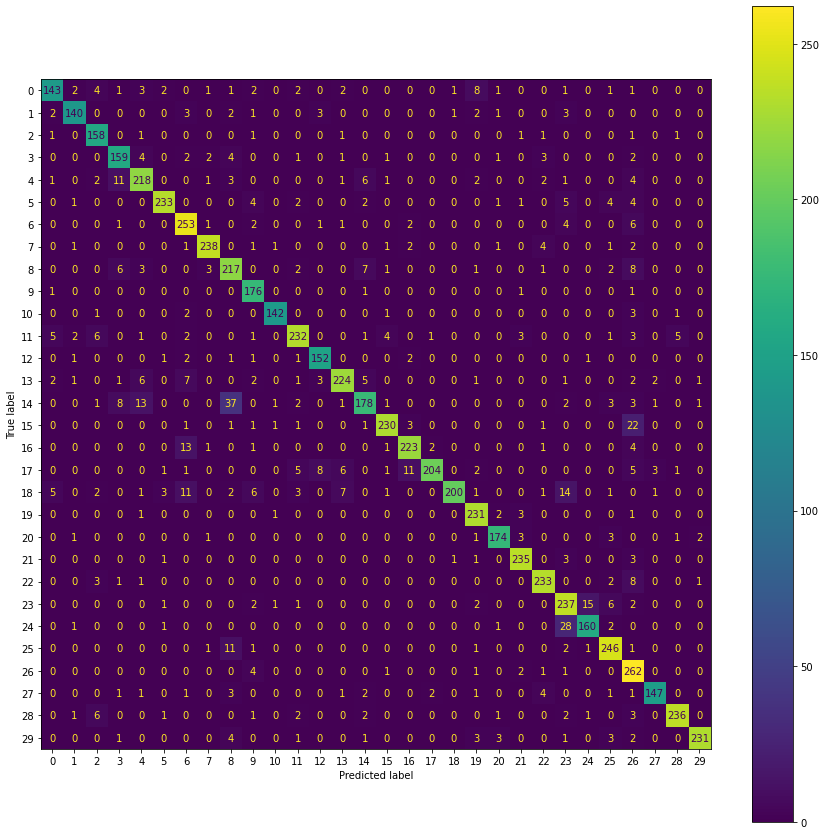

In [139]:
cm = confusion_matrix(y_true_tensor.tolist(), y_pred_tensor.argmax(1).tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(30))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)

## Фрагмент обучения на аугментациях Shift()

In [159]:
# с 1 по 3 эпохи
epochs = 3
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(val_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 7.151709  [    0/102188]
loss: 2.661512  [ 6400/102188]
loss: 1.876535  [12800/102188]
loss: 1.463995  [19200/102188]
loss: 0.968687  [25600/102188]
loss: 0.953217  [32000/102188]
loss: 0.694287  [38400/102188]
loss: 0.754126  [44800/102188]
loss: 0.546284  [51200/102188]
loss: 0.491007  [57600/102188]
loss: 0.469137  [64000/102188]
loss: 0.501460  [70400/102188]
loss: 0.366232  [76800/102188]
loss: 0.467721  [83200/102188]
loss: 0.470400  [89600/102188]
loss: 0.472265  [96000/102188]
[]
Val Error: 
 Accuracy: 87.4%, Avg loss: 0.404373 

Epoch 2
-------------------------------
loss: 0.262595  [    0/102188]
loss: 0.300322  [ 6400/102188]
loss: 0.480808  [12800/102188]
loss: 0.407014  [19200/102188]
loss: 0.281689  [25600/102188]
loss: 0.513824  [32000/102188]
loss: 0.335475  [38400/102188]
loss: 0.331409  [44800/102188]
loss: 0.215304  [51200/102188]
loss: 0.257926  [57600/102188]
loss: 0.378554  [64000/102188]
loss: 0.177805  [70400/102188

In [163]:
# model.eval()
y_true, y_pred = test(test_dataloader, model)

Test Error: 
 Accuracy: 91.7



In [164]:
y_true_tensor = torch.cat((torch.cat(y_true[:1+1]),torch.cat(y_true[1+1:])))
y_pred_tensor = torch.cat((torch.cat(y_pred[:1+1]),torch.cat(y_pred[1+1:])))
print(classification_report(y_true_tensor.tolist(), y_pred_tensor.argmax(1).tolist()))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       176
           1       0.96      0.87      0.91       158
           2       0.94      0.95      0.95       166
           3       0.93      0.90      0.91       180
           4       0.88      0.89      0.88       253
           5       0.95      0.94      0.95       257
           6       0.92      0.90      0.91       271
           7       0.91      0.91      0.91       253
           8       0.85      0.82      0.84       251
           9       0.94      0.96      0.95       180
          10       0.93      0.99      0.96       150
          11       0.91      0.95      0.93       267
          12       0.94      0.95      0.94       162
          13       0.99      0.90      0.94       259
          14       0.82      0.89      0.86       252
          15       0.96      0.90      0.93       262
          16       0.93      0.91      0.92       246
          17       0.96    

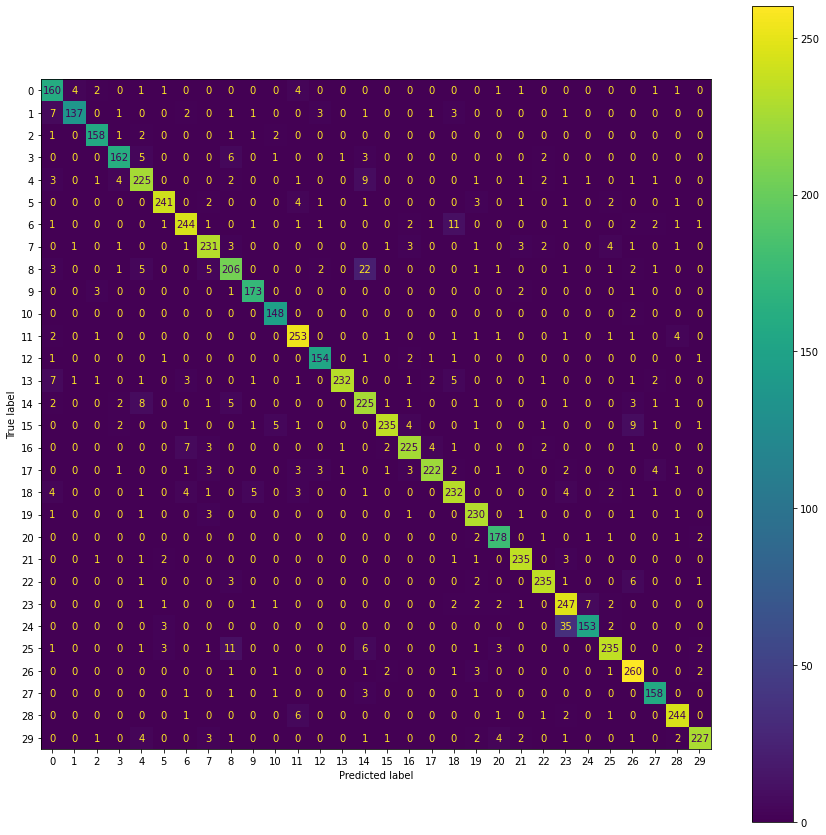

In [165]:
cm = confusion_matrix(y_true_tensor.tolist(), y_pred_tensor.argmax(1).tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(30))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)

In [ ]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation(val_dataloader, model, loss_fn)

print("Done!")